In [1]:
import fastai.vision.widgets as widgets

from fastai.vision.all import *


def search_images_ddg(key,max_n=200):
     """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images """
     url        = 'https://duckduckgo.com/'
     params     = {'q':key}
     res        = requests.post(url,data=params)
     searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
     if not searchObj: print('Token Parsing Failed !'); return
     requestUrl = url + 'i.js'
     headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'}
     params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
     urls       = []
     while True:
         try:
             res  = requests.get(requestUrl,headers=headers,params=params)
             data = json.loads(res.text)
             for obj in data['results']:
                 urls.append(obj['image'])
                 max_n = max_n - 1
                 if max_n < 1: return L(set(urls))     # dedupe                                                                                       
             if 'next' not in data: return L(set(urls))
             requestUrl = url + data['next']
         except:
             pass

Download mushroom images, only if they have not been downloaded earlier

In [2]:
mushroom_species = ['Amanita virosa', 'Agaricus arvensis', 'Agaricus sylvicola', 'Agaricus sylvaticus', 'Agaricus langei']
path = Path('mushroom')

if not path.exists():
    path.mkdir()
    for sp in mushroom_species:
        print(f'Downloading images of {sp}...', end = '')
        dest = (path/sp)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(sp)
        download_images(dest, urls=results)
        print(" done.")

In [3]:
fns = get_image_files(path)
fns

(#815) [Path('mushroom/Amanita virosa/00000047.jpg'),Path('mushroom/Amanita virosa/00000159.jpg'),Path('mushroom/Amanita virosa/00000107.jpg'),Path('mushroom/Amanita virosa/00000036.jpg'),Path('mushroom/Amanita virosa/00000097.jpg'),Path('mushroom/Amanita virosa/00000110.jpg'),Path('mushroom/Amanita virosa/00000029.jpg'),Path('mushroom/Amanita virosa/00000112.jpg'),Path('mushroom/Amanita virosa/00000132.JPG'),Path('mushroom/Amanita virosa/00000091.jpg')...]

In [4]:
failed = verify_images(fns)
failed

(#0) []

In [5]:
failed.map(Path.unlink);

In [6]:
mushroom_data = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)

dls = mushroom_data.dataloaders(path)

In [7]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(8)

epoch,train_loss,valid_loss,error_rate,time
0,2.288589,1.226200,0.447853,00:13


epoch,train_loss,valid_loss,error_rate,time
0,1.525554,1.032184,0.404908,00:14
1,1.309981,1.047747,0.361963,00:14
2,1.144762,0.983199,0.319018,00:13
3,0.997122,1.002739,0.325153,00:13
4,0.885313,0.975222,0.312883,00:14
5,0.766764,0.935756,0.325153,00:14
6,0.676110,0.942810,0.312883,00:13
7,0.610097,0.940337,0.312883,00:13


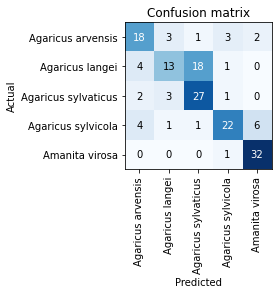

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

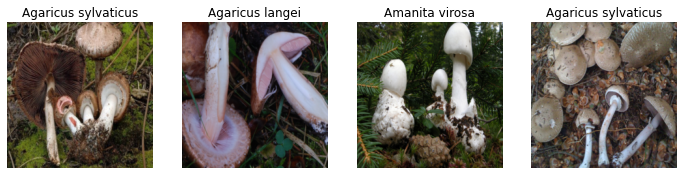

In [9]:
dls.valid.show_batch(max_n=4, nrows=1)

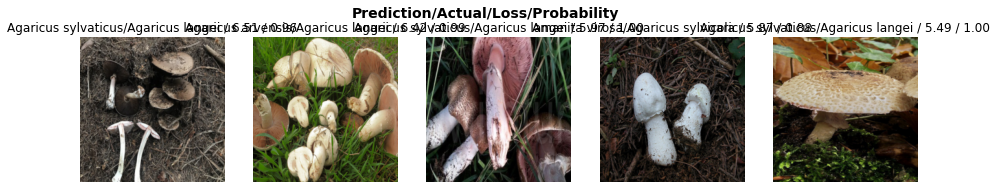

In [10]:
interp.plot_top_losses(5, nrows=1)

In [11]:
cleaner = widgets.ImageClassifierCleaner(learn)
cleaner

In [12]:
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [13]:
learn.export()
root_path = Path()
root_path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]